# Project 3 – Predicting a Categorical Target and Evaluating Performance  
**Dataset:** Titanic  
**Author:** Beth Spornitz  
**Date:** November 1, 2025

### Introduction  
We will use the Titanic dataset to predict passenger survival using 3 methods:
- Decision Tree
- Support Vector Machine
- Neural Network  

We will compare their performance across three feature sets and reflect on each. 

## Section 1.  Import and Inspect the Data


In [204]:
# Import all required libraries once at the top

# Core libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# scikit-learn utilities
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap
from pandas.api.types import is_integer_dtype



# Load dataset
titanic = sns.load_dataset('titanic')
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2. Data Exploration and Preparation

### 2.1 Handle Missing Values and Clean Data
We’ll impute missing values for key features to ensure the models receive complete inputs.    

Some passengers don’t have an age or embark town recorded (blank cells).  
- For age: we replace blanks with the middle value (median) so we don’t skew too old/young.  
- For embark town: we replace blanks with the most common town (mode).  

In [205]:
# - Fill missing ages with median
median_age = titanic['age'].median()
titanic['age'] = titanic['age'].fillna(median_age)

# - Fill missing embark_town with mode
mode_embark = titanic['embark_town'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].fillna(mode_embark)


### 2.2 Feature Engineering
Create new features and convert categorical data to numerical form for modeling.  

Models prefer numbers, not words.  
- We build family_size (bigger families may behave differently).  
- We convert sex, embarked, alone to numeric codes so the models can calculate with them.  

In [206]:
# - Add family_size = sibsp + parch + 1
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# - Convert sex, embarked, and alone to numeric values
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['alone'] = titanic['alone'].astype(int)


In [207]:
titanic[['alone']].head(10)


,alone
0,0
1,0
2,1
3,0
4,1
5,1
6,1
7,0
8,0
9,0


In [208]:
# 1) Missing values fixed?
print("Missing after impute:")
print(titanic[['age', 'embark_town']].isna().sum())

# 2) Encodings correct?
print("\nUnique codes:")
print("sex ->", sorted(titanic['sex'].dropna().unique().tolist()))
print("embarked ->", sorted(titanic['embarked'].dropna().unique().tolist()))
print("alone dtype ->", titanic['alone'].dtype)
print("family_size min/max ->", int(titanic['family_size'].min()), int(titanic['family_size'].max()))

# 3) Hard assertions (will raise if something is wrong)
assert titanic['age'].isna().sum() == 0, "Age still has missing values."
assert titanic['embark_town'].isna().sum() == 0, "Embark town still has missing values."
assert set(titanic['sex'].dropna().unique()) <= {0, 1}, "sex not mapped to {0,1}."
assert set(titanic['embarked'].dropna().unique()) <= {0, 1, 2}, "embarked not mapped to {0,1,2}."
assert is_integer_dtype(titanic['alone']), "alone is not integer dtype."

Missing after impute:
age            0
embark_town    0
dtype: int64

Unique codes:
sex -> [0, 1]
embarked -> [0.0, 1.0, 2.0]
alone dtype -> int64
family_size min/max -> 1 11


## Section 3. Feature Selection and Justification

### 3.1 Choose features and target

We’re going to test three different “views” of the same problem:  
- Case 1: predict survival using only “alone” (were they traveling alone?).  
- Case 2: predict survival using only age.  
- Case 3: predict survival using age + family_size together.  
  
We will set up three cases:
- Case 1: `X = ['alone']` → `y = survived`
- Case 2: `X = ['age']` (drop NA rows) → `y = survived`
- Case 3: `X = ['age','family_size']` (drop NA rows) → `y = survived`

### 3.2 Define X (features) and y (target)
We will assign the input features and target for each case.  
- X = inputs/features; y = the answer we want the model to predict (survived 0/1).  


In [209]:
# Case 1: Feature = alone

# Select the feature 'alone' as input
X1 = titanic[['alone']]
# Select 'survived' as the target for the same rows
y1 = titanic['survived']

# Case 2: Feature = age (drop missing)

# Select the feature 'age', but drop rows where age is missing
X2 = titanic[['age']].dropna()
# Select the matching 'survived' values using the same index
y2 = titanic.loc[X2.index, 'survived']

# Case 3: Features = age + family_size (drop missing)

# Select both 'age' and 'family_size', and drop rows where missing (na)
X3 = titanic[['age', 'family_size']].dropna()
# Select the corresponding 'survived' values for those rows
y3 = titanic.loc[X3.index, 'survived']


In [ ]:
# QC checks for Section 3.2 — run right after defining X1,y1; X2,y2; X3,y3

def qc_pair(X, y, name):  # noqa: D103, N803
    print(f"\n{name}")
    print("X shape:", X.shape, "| y length:", len(y))
    print("NaNs -> X:", int(X.isna().sum().sum()), "| y:", int(y.isna().sum()))
    # Index alignment (same rows in X and y)
    assert X.index.equals(y.index), f"{name}: X and y indices are misaligned."
    # Quick class balance view
    print("y value counts:")
    print(y.value_counts(dropna=False).to_string())

qc_pair(X1, y1, "Case 1 (alone)")
qc_pair(X2, y2, "Case 2 (age)")
qc_pair(X3, y3, "Case 3 (age + family_size)")



Case 1 (alone)
X shape: (891, 1) | y length: 891
NaNs -> X: 0 | y: 0
y value counts:
survived
0    549
1    342

Case 2 (age)
X shape: (891, 1) | y length: 891
NaNs -> X: 0 | y: 0
y value counts:
survived
0    549
1    342

Case 3 (age + family_size)
X shape: (891, 2) | y length: 891
NaNs -> X: 0 | y: 0
y value counts:
survived
0    549
1    342


### Reflection 3
Why were these features selected?  
- These features were chosen because they reflect human factors that could affect survival on the Titanic.  
  
Are there features that are likely to be highly predictive of survival? 
- I believe that age + family size will be the best predictor of the three we have chosen.  We know from previous studies of the data that sex and passenger class are the strongest predictors of survival, but we have not added those to this project yet.  


## Section 4. Train a Classification Model (Decision Tree)

### 4.1 Split the Data (Stratified 80/20)
We split our data into train (model learns) and test (we check if it learned well).
- Stratified means the ratio of survivors/non-survivors is similar in both sets (fair comparison).

Three cases will be analyzed:

- Case 1: `X = ['alone']` → `y = survived`  
- Case 2: `X = ['age']` → `y = survived`  
- Case 3: `X = ['age', 'family_size']` → `y = survived`


In [211]:
# Case 1: Feature = alone
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx1, test_idx1 in splitter1.split(X1, y1):

    X1_train = X1.iloc[train_idx1]
    X1_test  = X1.iloc[test_idx1]
    y1_train = y1.iloc[train_idx1]
    y1_test  = y1.iloc[test_idx1]

print('Case 1 - Alone:')
print('Train size:', len(X1_train), '| Test size:', len(X1_test))



Case 1 - Alone:
Train size: 712 | Test size: 179


In [212]:
# Case 2: Feature = age
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx2, test_idx2 in splitter2.split(X2, y2):
    X2_train = X2.iloc[train_idx2]
    X2_test  = X2.iloc[test_idx2]
    y2_train = y2.iloc[train_idx2]
    y2_test  = y2.iloc[test_idx2]

print('Case 2 - Age:')
print('Train size:', len(X2_train), '| Test size:', len(X2_test))

Case 2 - Age:
Train size: 712 | Test size: 179


In [213]:
# Case 3: Features = age + family_size
splitter3 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx3, test_idx3 in splitter3.split(X3, y3):
    X3_train = X3.iloc[train_idx3]
    X3_test  = X3.iloc[test_idx3]
    y3_train = y3.iloc[train_idx3]
    y3_test  = y3.iloc[test_idx3]

print('Case 3 - Age + Family Size:')
print('Train size:', len(X3_train), '| Test size:', len(X3_test))

Case 3 - Age + Family Size:
Train size: 712 | Test size: 179


In [ ]:
# QC checks for Section 4.1 — run right after the three stratified_split calls

def qc_split(X, y, X_tr, X_te, y_tr, y_te, label):  # noqa: D103, N803
    # No overlap between train and test
    assert set(X_tr.index).isdisjoint(set(X_te.index)), f"{label}: Train/Test index overlap!"
    # Sizes add up
    assert len(X_tr) + len(X_te) == len(X), f"{label}: Split sizes don't add up."
    # NaNs check
    assert X_tr.isna().sum().sum() == 0 and X_te.isna().sum().sum() == 0, f"{label}: NaNs in X after split."
    assert y_tr.isna().sum() == 0 and y_te.isna().sum() == 0, f"{label}: NaNs in y after split."
    # Stratification sanity: compare survival rate
    overall = y.mean()
    tr_rate = y_tr.mean()
    te_rate = y_te.mean()
    print(f"{label}: overall={overall:.3f} | train={tr_rate:.3f} | test={te_rate:.3f}")
    # Allow small drift (5 percentage points)
    assert abs(tr_rate - overall) < 0.05, f"{label}: Train class ratio drift > 5%."
    assert abs(te_rate - overall) < 0.05, f"{label}: Test class ratio drift > 5%."

qc_split(X1, y1, X1_train, X1_test, y1_train, y1_test, "Case 1")
qc_split(X2, y2, X2_train, X2_test, y2_train, y2_test, "Case 2")
qc_split(X3, y3, X3_train, X3_test, y3_train, y3_test, "Case 3")


Case 1: overall=0.384 | train=0.383 | test=0.385
Case 2: overall=0.384 | train=0.383 | test=0.385
Case 3: overall=0.384 | train=0.383 | test=0.385


In [215]:
# Print train/test sizes for verification
for label, Xtr, Xte in [
    ('Case 1 - Alone', X1_train, X1_test),
    ('Case 2 - Age', X2_train, X2_test),
    ('Case 3 - Age + Family Size', X3_train, X3_test),
]:
    print(f'{label}: Train size = {len(Xtr)}, Test size = {len(Xte)}')


Case 1 - Alone: Train size = 712, Test size = 179
Case 2 - Age: Train size = 712, Test size = 179
Case 3 - Age + Family Size: Train size = 712, Test size = 179


### 4.2 Create and Train Decision Tree Models
We will create a Decision Tree model for each feature case.  

A Decision Tree is a flowchart of yes/no questions to guess “survived?”  
- We make one tree per case and let it learn patterns from the training rows.  

In [216]:

# Case 1: Train Decision Tree on 'alone'
tree_model1 = DecisionTreeClassifier()
tree_model1.fit(X1_train, y1_train)

# Case 2: Train Decision Tree on 'age'
tree_model2 = DecisionTreeClassifier()
tree_model2.fit(X2_train, y2_train)

# Case 3: Train Decision Tree on 'age' and 'family_size'
tree_model3 = DecisionTreeClassifier()
tree_model3.fit(X3_train, y3_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 4.3 Predict and Evaluate Model Performance
We will print classification reports for each Decision Tree case using both training and test sets.

We ask the model to guess survivors on data it saw (train) and data it didn’t (test).  
- The classification report gives:  
    - Precision: When we predict “survived,” how often are we right?  
    - Recall: Of everyone who actually survived, how many did we catch?  
    - F1: A balanced score between precision and recall.  
    - Accuracy: Overall % correct.  

In [217]:
# Predict on training data
y1_pred = tree_model1.predict(X1_train)
print("Results for Decision Tree on training data (Case 1 - alone):")
print(classification_report(y1_train, y1_pred))

# Predict on test data
y1_test_pred = tree_model1.predict(X1_test)
print("Results for Decision Tree on test data (Case 1 - alone):")
print(classification_report(y1_test, y1_test_pred))

# Predict on training data
y2_pred = tree_model2.predict(X2_train)
print("Results for Decision Tree on training data (Case 2 - age):")
print(classification_report(y2_train, y2_pred))

# Predict on test data
y2_test_pred = tree_model2.predict(X2_test)
print("Results for Decision Tree on test data (Case 2 - age):")
print(classification_report(y2_test, y2_test_pred))

# Predict on training data
y3_pred = tree_model3.predict(X3_train)
print("Results for Decision Tree on training data (Case 3 - age + family_size):")
print(classification_report(y3_train, y3_pred))

# Predict on test data
y3_test_pred = tree_model3.predict(X3_test)
print("Results for Decision Tree on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_test_pred))

Results for Decision Tree on training data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       439
           1       0.50      0.51      0.51       273

    accuracy                           0.62       712
   macro avg       0.60      0.60      0.60       712
weighted avg       0.62      0.62      0.62       712

Results for Decision Tree on test data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179

Results for Decision Tree on training data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       439
           1       0.69      0.29      0.41       273

    a

In [218]:
for name in ["y1_pred_test","y2_pred_test","y3_pred_test"]:
    print(name, "exists?", name in locals())


y1_pred_test exists? True
y2_pred_test exists? True
y3_pred_test exists? True


### 4.4 Report Confusion Matrix (heatmaps)
We will plot confusion matrices for each Decision Tree case using Seaborn.

What this chart is: a tiny 2×2 scoreboard of right vs wrong outputs of a prediction.
- Rows = what really happened (Actual).
  - Row 0 = actually did not survive
  - Row 1 = actually did survive
- Columns = what the model predicted.
  - Col 0 = predicted not survive
  - Col 1 = predicted survive

So the four boxes mean:
- Top-left (0,0) = TN (True Negatives): model said “not survive” and that was correct.
- Top-right (0,1) = FP (False Positives): model said “survive” but they didn’t.
- Bottom-left (1,0) = FN (False Negatives): model said “not survive” but they did.
- Bottom-right (1,1) = TP (True Positives): model said “survive” and that was correct.

How to read it in 5 seconds:
- Big bottom-right? Good at catching survivors (high recall for “survived”).
- Big top-left? Good at catching non-survivors (common baseline).
- Big top-right? Over-predicting survival (lots of false alarms).
- Big bottom-left? Missing survivors (bad for recall of “survived”).


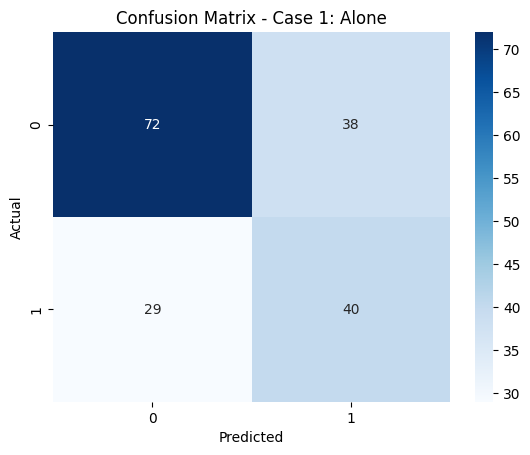

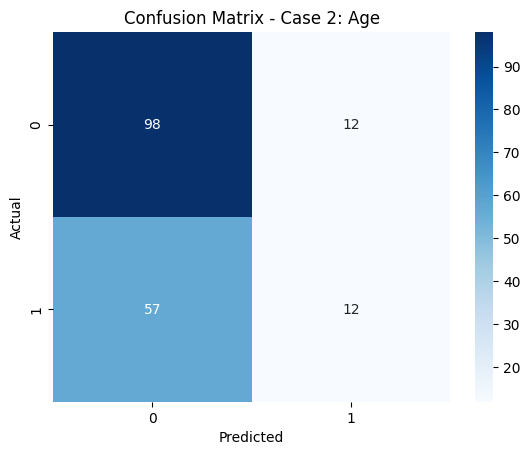

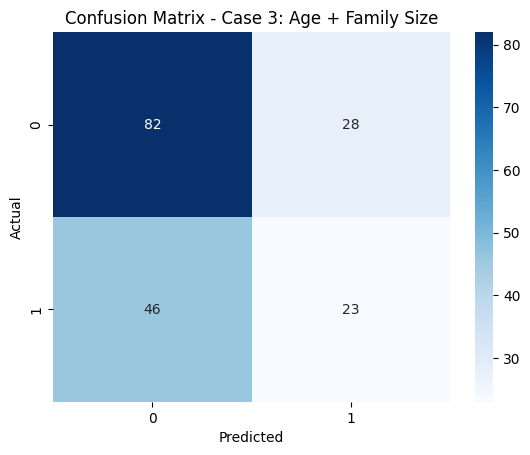

In [219]:
# Create confusion matrix for test predictions (Case 1)
cm1 = confusion_matrix(y1_test, y1_test_pred)

# Plot heatmap
sns.heatmap(cm1, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 1: Alone')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Create confusion matrix for test predictions (Case 2)
cm2 = confusion_matrix(y2_test, y2_test_pred)

# Plot heatmap
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 2: Age')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Create confusion matrix for test predictions (Case 3)
cm3 = confusion_matrix(y3_test, y3_test_pred)

# Plot heatmap
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 3: Age + Family Size')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.5 Plot Decision Trees
We will visualize each Decision Tree model using plot_tree.


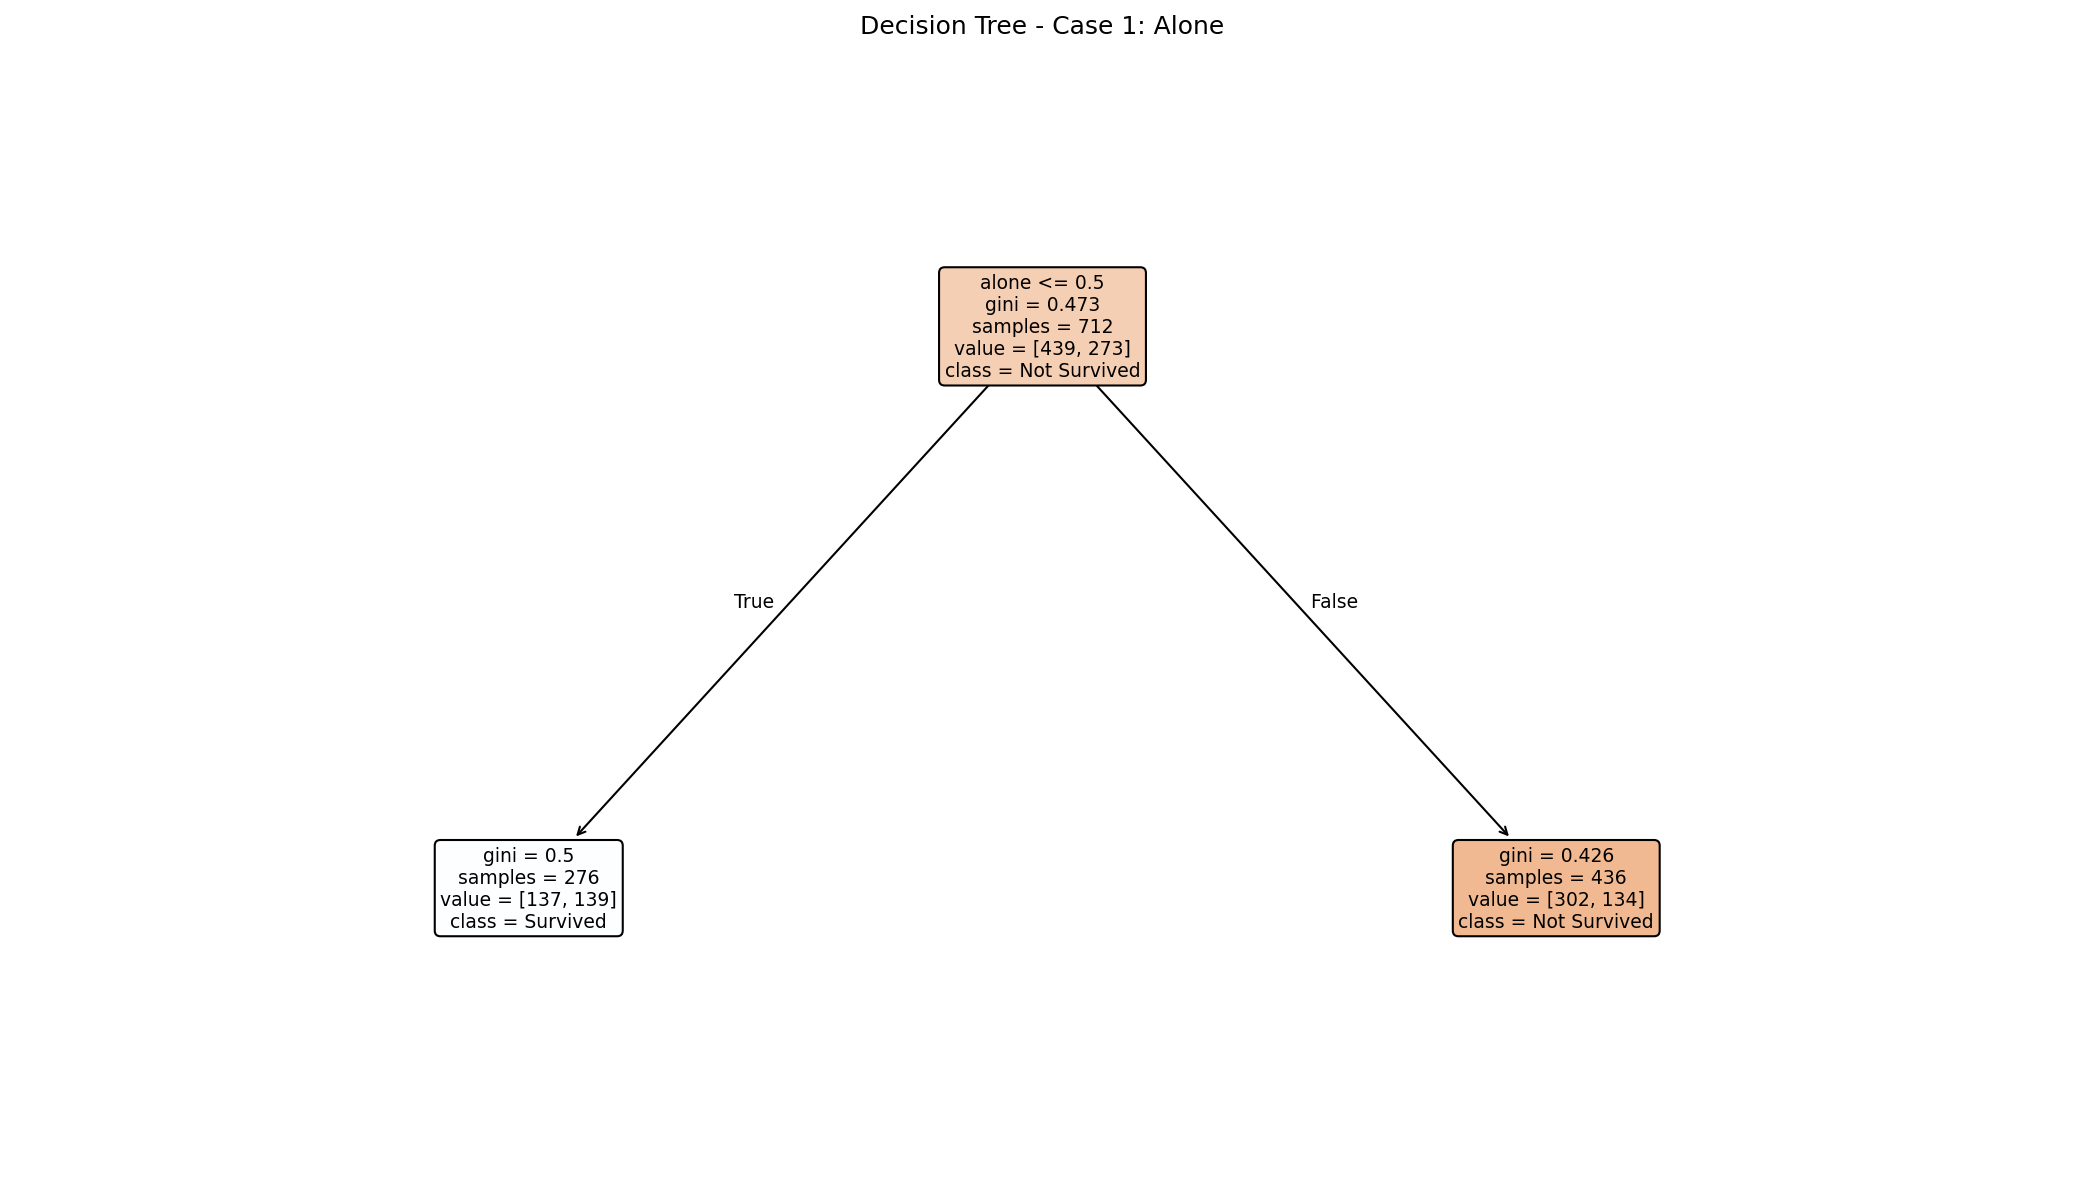

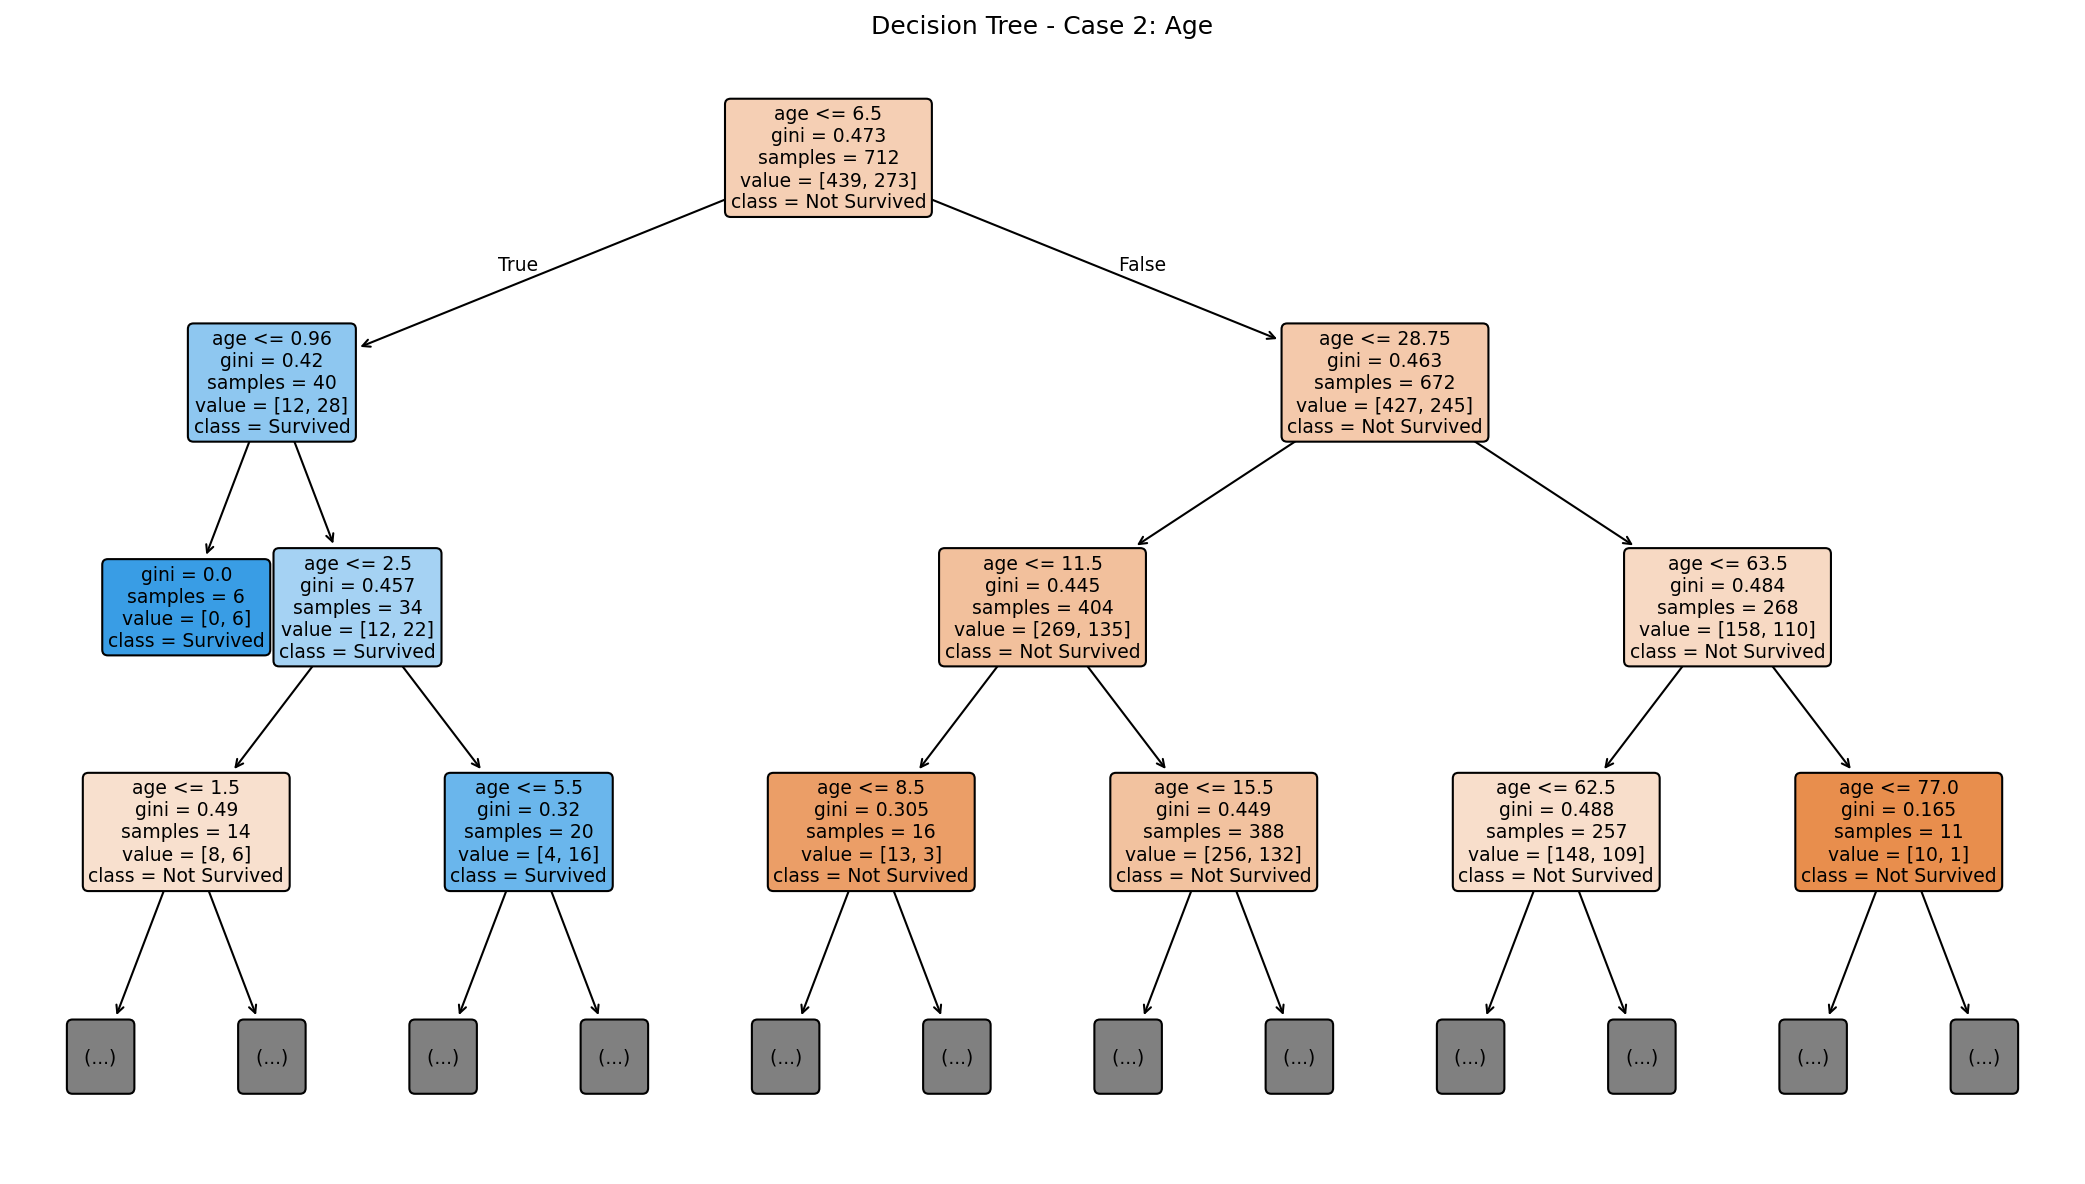

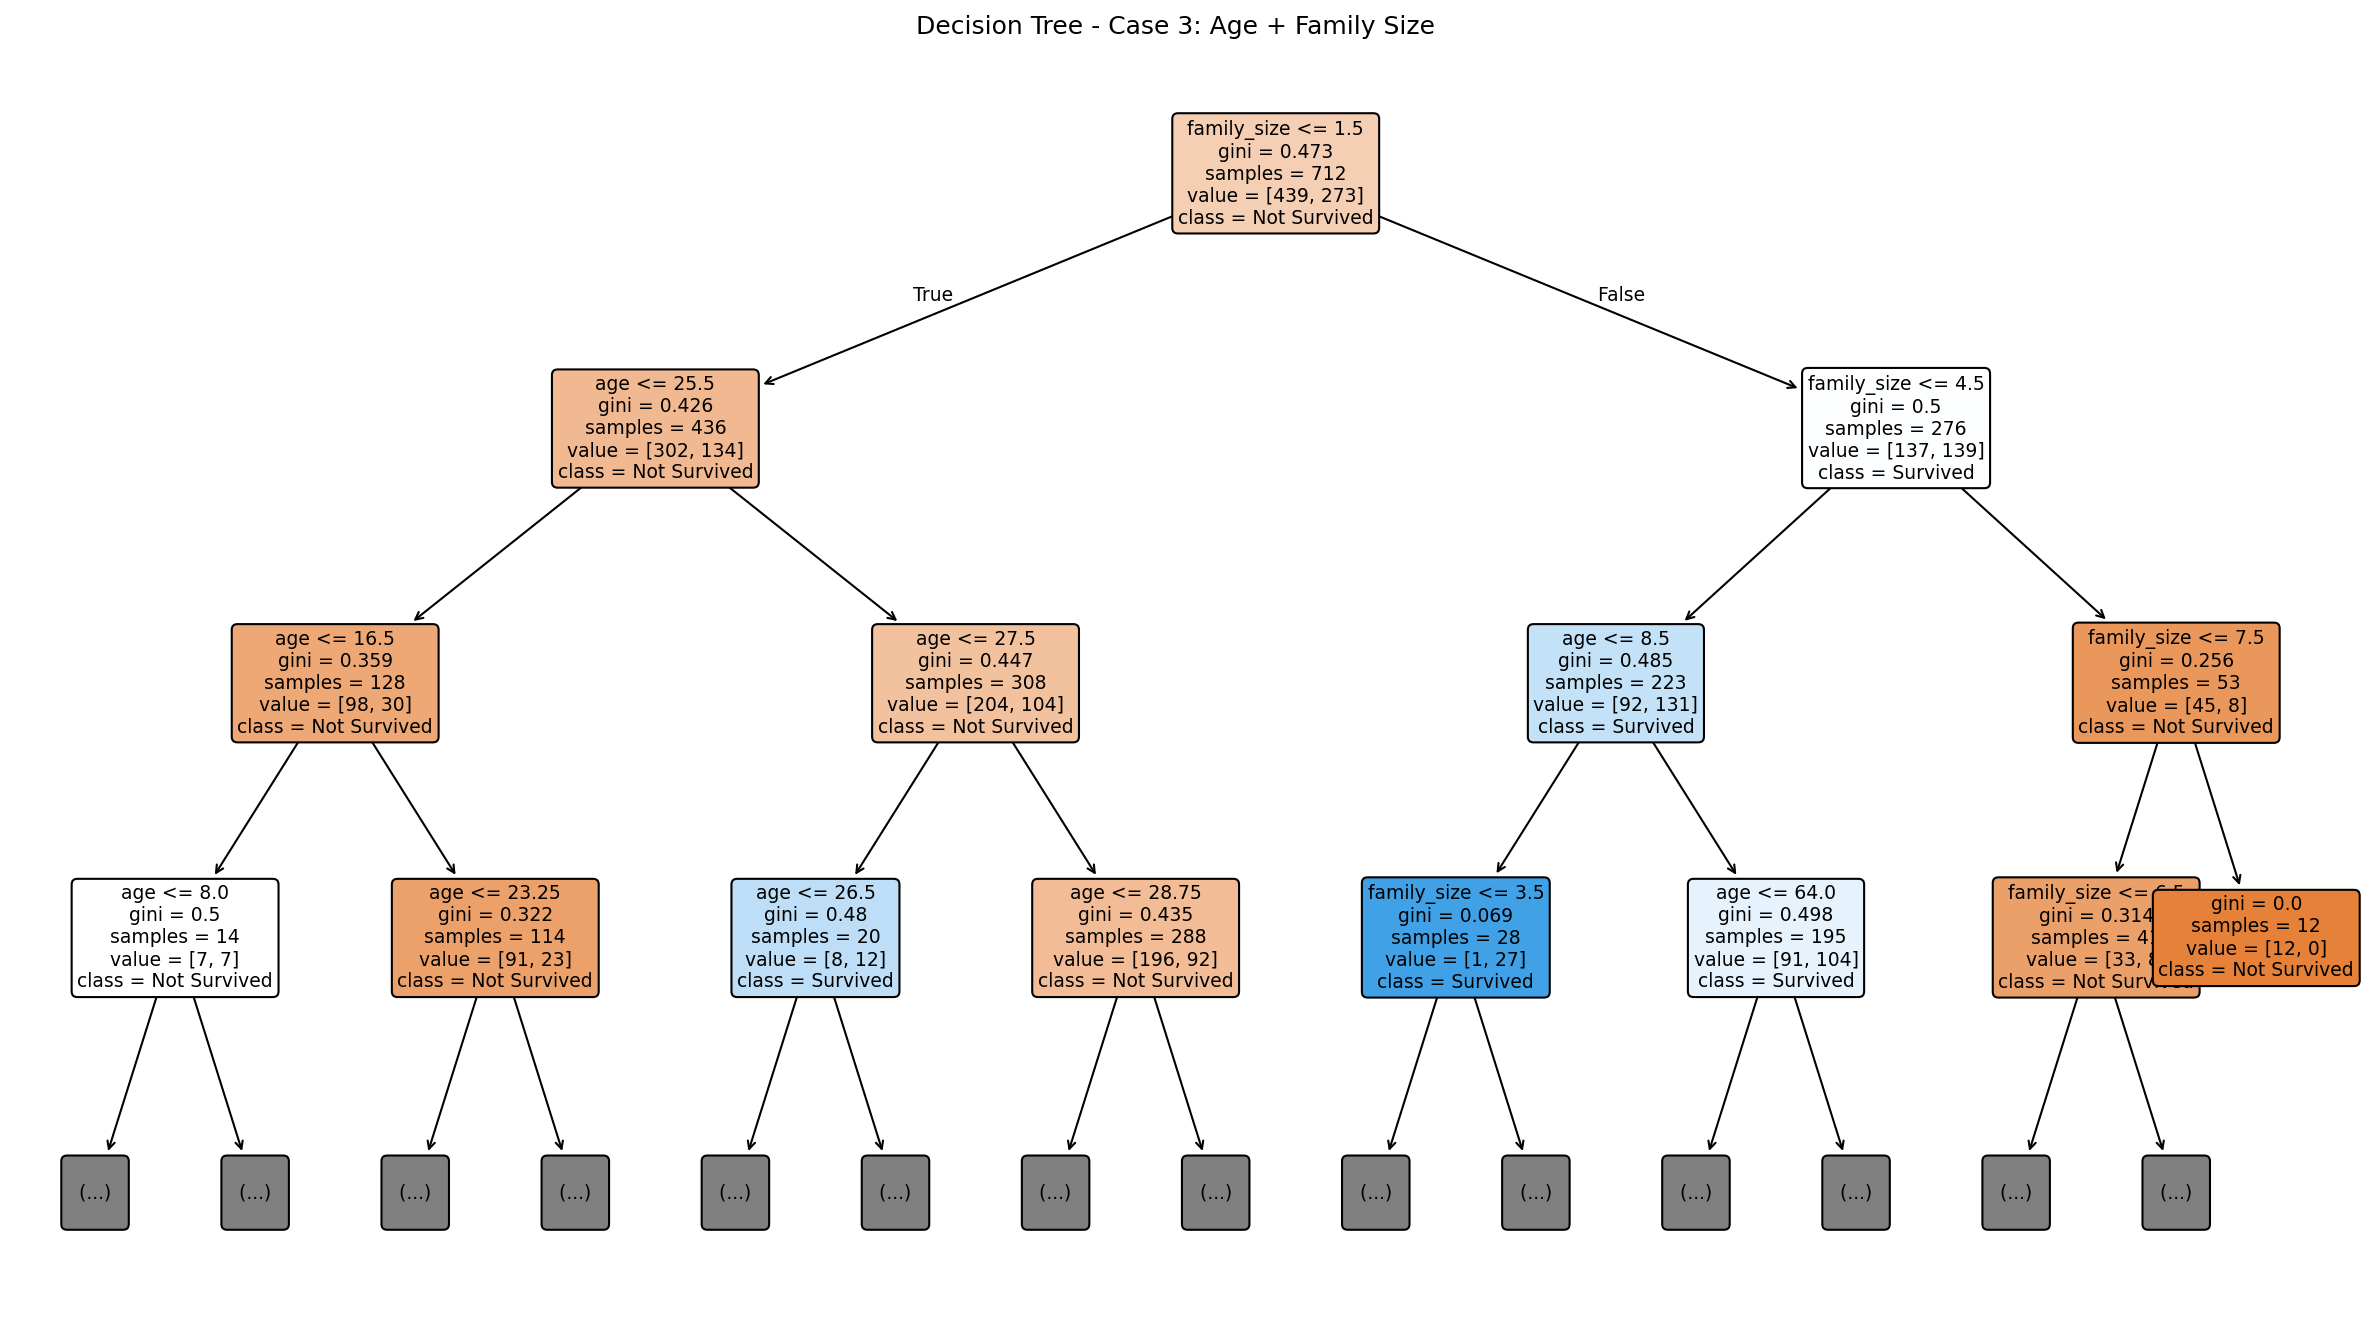

In [220]:

# Case 1
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)
plot_tree(
    tree_model1,
    feature_names=X1.columns,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=3,       # show up to 3 levels to avoid clutter (doesn't change the model)
    ax=ax
)
ax.set_title('Decision Tree - Case 1: Alone')
fig.tight_layout()
fig.savefig("tree_case1_alone.png", dpi=200, bbox_inches='tight')
plt.show()

# Case 2
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)
plot_tree(
    tree_model2,
    feature_names=X2.columns,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=3,
    ax=ax
)
ax.set_title('Decision Tree - Case 2: Age')
fig.tight_layout()
fig.savefig("tree_case2_age.png", dpi=200, bbox_inches='tight')
plt.show()

# Case 3
fig, ax = plt.subplots(figsize=(16, 9), dpi=150)
plot_tree(
    tree_model3,
    feature_names=X3.columns,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=3,
    ax=ax
)
ax.set_title('Decision Tree - Case 3: Age + Family Size')
fig.tight_layout()
fig.savefig("tree_case3_age_family.png", dpi=200, bbox_inches='tight')
plt.show()


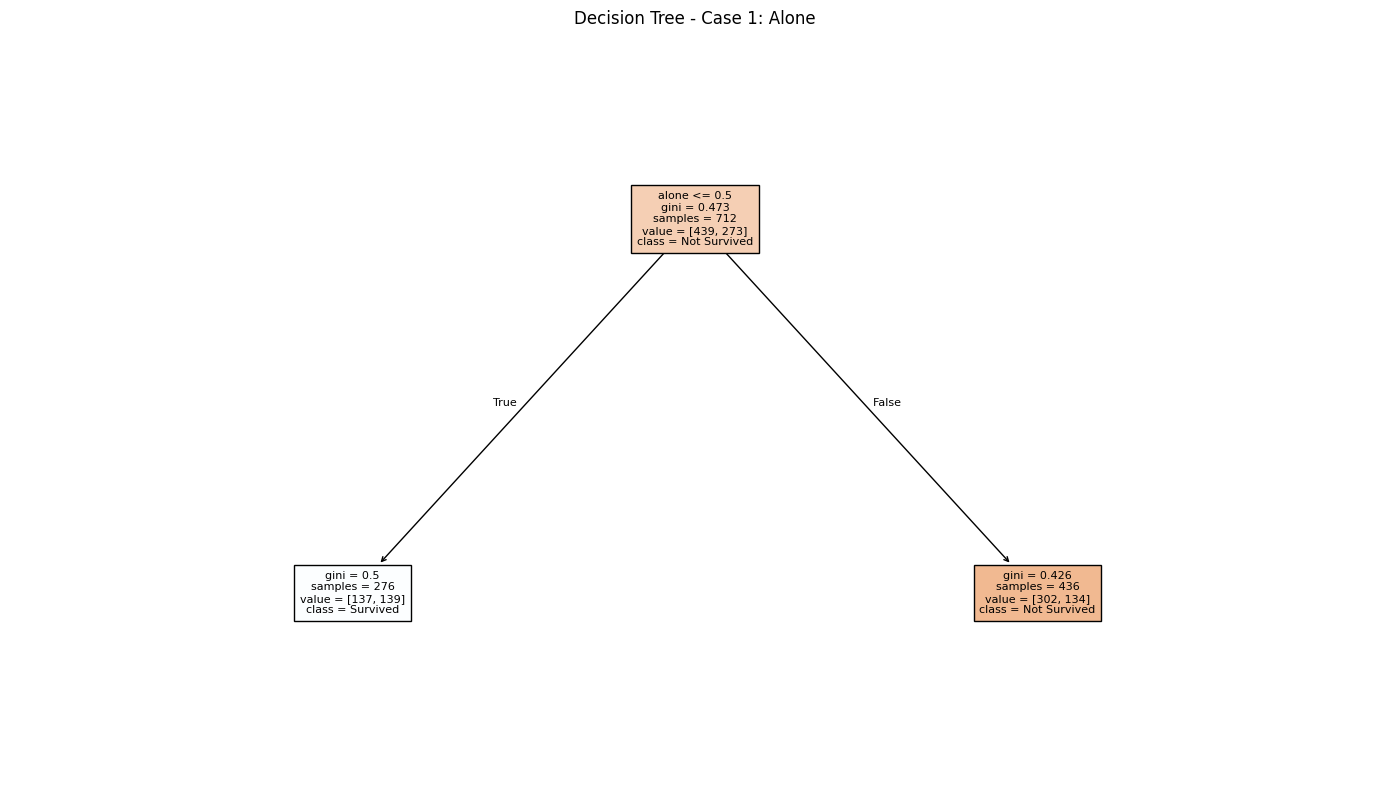

In [221]:
# Plot Decision Tree for Case 1

fig = plt.figure(figsize=(14, 8))  # wider and taller for readability
plot_tree(
    tree_model1,
    feature_names=X1.columns,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    fontsize=8,
)  # small but readable text
plt.title("Decision Tree - Case 1: Alone")
plt.tight_layout()  # avoids text overlap
plt.show()

# Save image properly — includes full margins
fig.savefig("tree_case1_alone.png", dpi=200, bbox_inches='tight')


#


Top of Decision Tree:
- alone <= 0.5  
    - This is the first question the tree asks. Since we converted "alone" to numbers, 0 = not alone (with family) and 1 = alone. So alone ≤ 0.5 really means: “Is this person NOT alone (so they have family onboard)?”
 - gini = 0.473
    - This tells us how "mixed" the group is. A gini of 0 would mean everyone in this group is the same (all survived or all died). 0.473 means this group contains a mix of both survived and not survived.
- samples = 712
  - This node includes 712 passengers after dropping rows with missing values.
- values = [439, 273]
  - Out of those 712 people: 439 did not survive, 273 survived. This matches the dataset imbalance (more people died than survived).
 - class = not survived
    - Because more people in this group died than survived, the model labels this group as “not survived”. This is the “majority vote.”


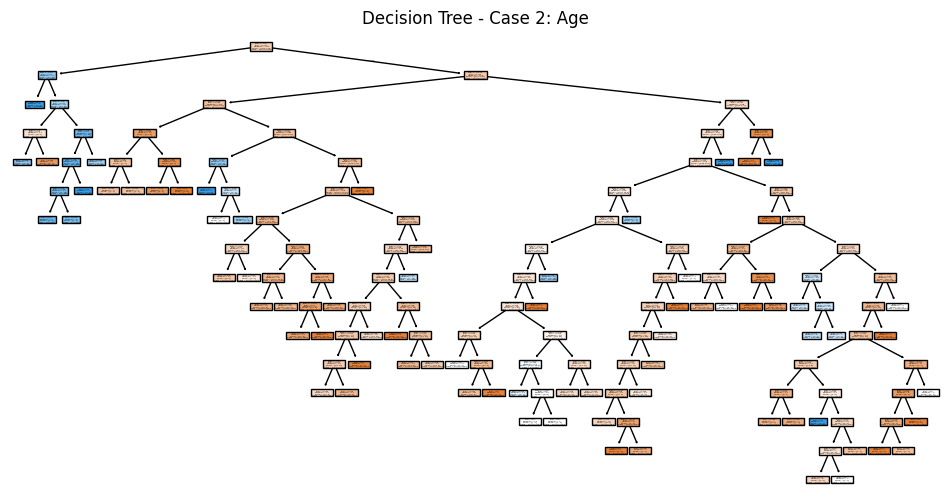

In [222]:
# Plot Decision Tree for Case 2
fig = plt.figure(figsize=(12, 6))
plot_tree(tree_model2,
          feature_names=X2.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 2: Age")
plt.show()

# Save image
fig.savefig("tree_case2_age.png")

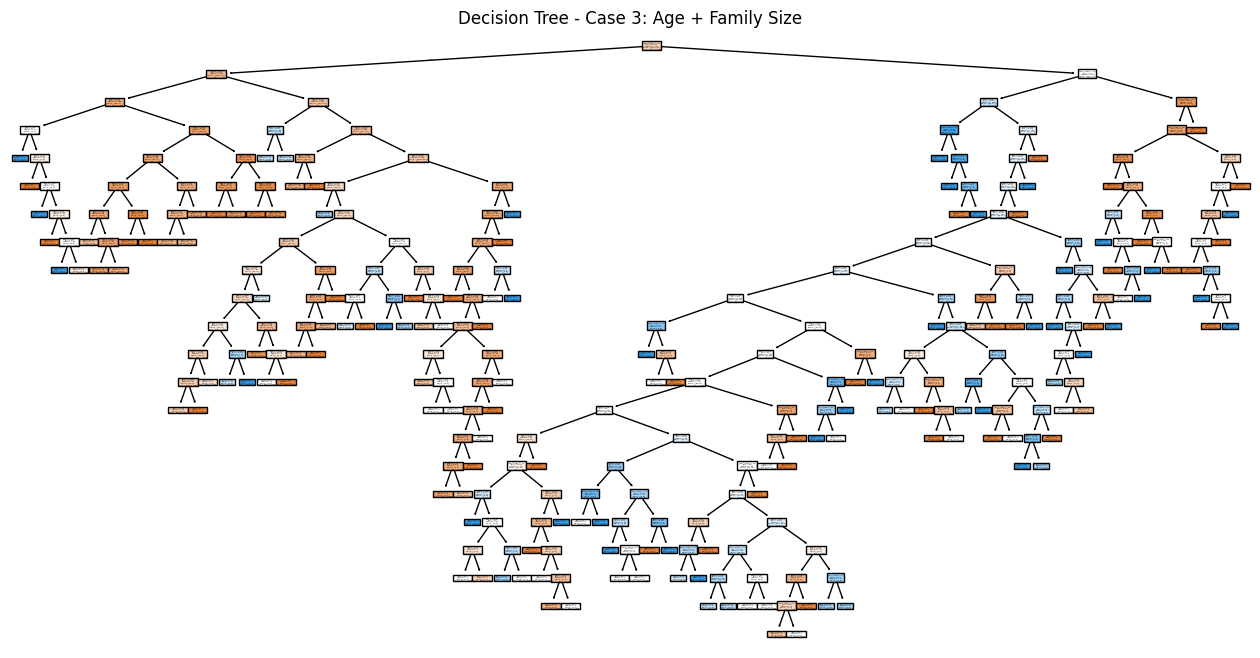

In [223]:
# Plot Decision Tree for Case 3
fig = plt.figure(figsize=(16, 8))
plot_tree(tree_model3,
          feature_names=X3.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 3: Age + Family Size")
plt.show()

# Save image
fig.savefig("tree_case3_age_family.png")

###  Reflection 4

How well did the different cases perform?
- Case 1 (alone): Test accuracy was around 0.63. This feature did an okay job and produced fairly balanced results.  
- Case 2 (age): This case performed the weakest (~0.61 accuracy) and especially struggled to correctly identify survivors. Age alone is not a strong predictor of survival.  
- Case 3 (age + family_size): This case had the highest training accuracy (~0.77), meaning it learned more meaningful survival patterns. However, its test accuracy dropped to ~0.5*, which suggests overfitting,  the model learned the training data well but did not generalize as well to new passengers.

Were any results surprising?
Yes. I expected that using more features (like age and family_size together) would automatically make the model perform better, but instead Case 3 performed better only on the training data. Its test results were worse than Case 1, showing that more features can make a model overfit. It was also surprising that age alone was not very helpful, even though children were more likely to survive.


Which inputs worked better?
- Most stable: Case 1 (alone), even though it is simple, it stayed consistent between training and testing results.  
- Most informative but slightly overfit: Case 3 (age + family_size),  it captured meaningful survival patterns (like families and younger people surviving more), but didn’t generalize as well.  
- Least effective: Case 2 (age only), it didn’t separate survivors and non-survivors clearly enough.



## Section 5. Compare Alternative Models (SVM and Neural Network)
In a Support Vector Machine (SVM), the kernel function defines how the algorithm transforms data to find a hyperplane that separates the classes.  
If the data is not linearly separable, changing the kernel can help the model find a better decision boundary.

SVC Kernel: Common Types  
- RBF (Radial Basis Function): most commonly used; handles non-linear data well (default)  
- Linear: best for linearly separable data (straight-line separation)  
- Polynomial: useful when the data follows a curved pattern  
- Sigmoid: similar to a neural network activation function; less common  

Commenting the options in and out in the code can be helpful.  
The analyst decides which to use based on their understanding of the results.



In [224]:
# Example Only: How to try different kernels (not run in this project)

# RBF Kernel (default)
# svc_model = SVC(kernel='rbf')
# svc_model.fit(X_train, y_train)

# Linear Kernel
# svc_model = SVC(kernel='linear')
# svc_model.fit(X_train, y_train)

# Polynomial Kernel (e.g., degree=3)
# svc_model = SVC(kernel='poly', degree=3)
# svc_model.fit(X_train, y_train)

# Sigmoid Kernel
# svc_model = SVC(kernel='sigmoid')
# svc_model.fit(X_train, y_train)



### 5.1 Train and Evaluate Support Vector Machine (SVM)
We will train an SVC model for each case using the default Radial Basis Function (RBF) kernel.


In [225]:
# --- 5.1 SVC (RBF kernel = default) ---

# Case 1 – 'alone'
svc_model1 = SVC()                 # default kernel='rbf'
svc_model1.fit(X1_train, y1_train)
y1_svc_pred = svc_model1.predict(X1_test)
print("SVC – Case 1 (alone)\n", classification_report(y1_test, y1_svc_pred))

# Case 2 – 'age'
svc_model2 = SVC()
svc_model2.fit(X2_train, y2_train)
y2_svc_pred = svc_model2.predict(X2_test)
print("\nSVC – Case 2 (age)\n", classification_report(y2_test, y2_svc_pred))

# Case 3 – 'age' + 'family_size'
svc_model3 = SVC()
svc_model3.fit(X3_train, y3_train)
y3_svc_pred = svc_model3.predict(X3_test)
print("\nSVC – Case 3 (age + family_size)\n", classification_report(y3_test, y3_svc_pred))

#Optional kernels to try later
# svc_model = SVC(kernel='linear')
# svc_model = SVC(kernel='poly', degree=3)
# svc_model = SVC(kernel='sigmoid')



SVC – Case 1 (alone)
               precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179


SVC – Case 2 (age)
               precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179


SVC – Case 3 (age + family_size)
               precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       

### 5.2 Visualize Support Vectors
We will visualize support vectors for Case 1 (feature = alone), Case 2 (feature = age), and Case 3 (features = age + family_size).



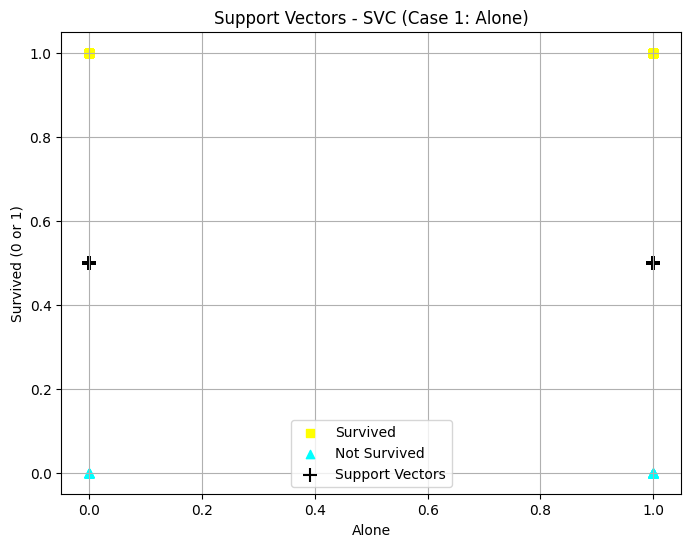

In [226]:
# Case 1: prepare separated values for survived vs not-survived
survived_alone = X1_test.loc[y1_test == 1, 'alone']
not_survived_alone = X1_test.loc[y1_test == 0, 'alone']

# Case 1: plot the 1D points using a y trick (0 for not survived, 1 for survived)
plt.figure(figsize=(8, 6))
plt.scatter(survived_alone, [1] * len(survived_alone), c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_alone, [0] * len(not_survived_alone), c='cyan', marker='^', label='Not Survived')

# Case 1: overlay the support vectors at y=0.5 so they’re visible between classes
if hasattr(svc_model1, 'support_vectors_'):
    support_x = svc_model1.support_vectors_[:, 0]
    plt.scatter(support_x, [0.5] * len(support_x), c='black', marker='+', s=100, label='Support Vectors')

# Case 1: add labels, title, legend, grid
plt.xlabel('Alone')
plt.ylabel('Survived (0 or 1)')
plt.title('Support Vectors - SVC (Case 1: Alone)')
plt.legend()
plt.grid(True)
plt.show()


What this shows: Points mark passengers; plus signs are support vectors (the critical cases SVM uses to place the boundary). With only one feature, separation is limited.

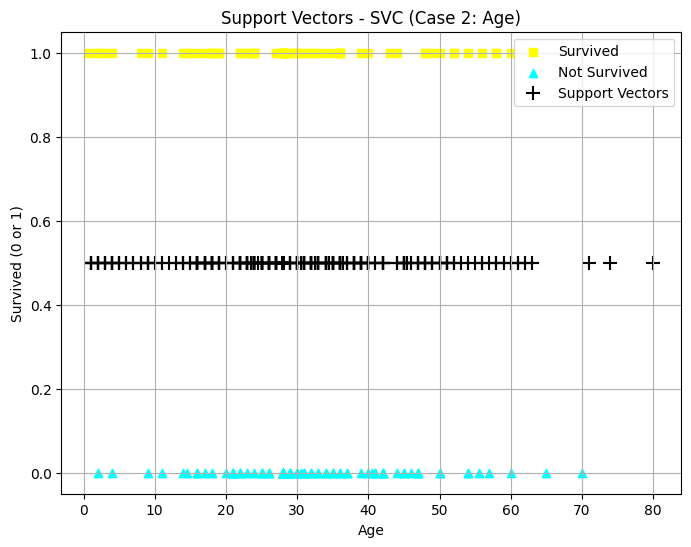

In [227]:
# Case 2: prepare separated values for survived vs not-survived - age only
survived_age = X2_test.loc[y2_test == 1, 'age']
not_survived_age = X2_test.loc[y2_test == 0, 'age']

# Case 2: plot the 1D age values against survival
plt.figure(figsize=(8, 6))
plt.scatter(survived_age, [1] * len(survived_age), c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_age, [0] * len(not_survived_age), c='cyan', marker='^', label='Not Survived')

# Case 2: overlay the support vectors at y=0.5 so they’re visible between classes
if hasattr(svc_model2, 'support_vectors_'):
    support_x = svc_model2.support_vectors_[:, 0]
    plt.scatter(support_x, [0.5] * len(support_x), c='black', marker='+', s=100, label='Support Vectors')

# Case 2: add labels, title, legend, grid
plt.xlabel('Age')
plt.ylabel('Survived (0 or 1)')
plt.title('Support Vectors - SVC (Case 2: Age)')
plt.legend()
plt.grid(True)
plt.show()


What this shows:
This plot displays each test passenger by age (x-axis) and survival (0 or 1, y-axis).
The “+” markers show the support vectors. These are the most important passengers used by SVM to determine where to separate survivors from non-survivors.
Since Case 2 only uses age, the model cannot make very accurate decisions (many overlapping points).

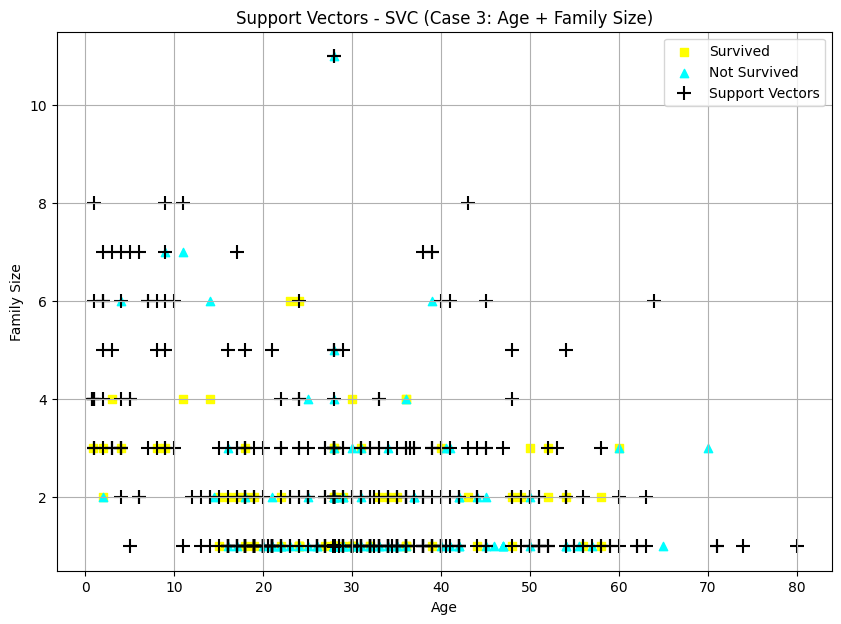

In [228]:
# Case 3: split test data into survived and not-survived subsets
survived_2d = X3_test[y3_test == 1]
not_survived_2d = X3_test[y3_test == 0]

# Case 3: plot 2D scatter of age vs family_size colored by survival
plt.figure(figsize=(10, 7))
plt.scatter(survived_2d['age'], survived_2d['family_size'], c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_2d['age'], not_survived_2d['family_size'], c='cyan', marker='^', label='Not Survived')

# Case 3: overlay support vectors from the trained SVC model
if hasattr(svc_model3, 'support_vectors_'):
    sv = svc_model3.support_vectors_
    plt.scatter(sv[:, 0], sv[:, 1], c='black', marker='+', s=100, label='Support Vectors')

# Case 3: add labels, title, legend, grid
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Support Vectors - SVC (Case 3: Age + Family Size)')
plt.legend()
plt.grid(True)
plt.show()


What this shows: Two features on the axes. Support vectors (+) are the key edge cases shaping SVM’s curved boundary between survived / not survived.

### 5.3 Train and Evaluate Neural Network (Case 3)
We will train a Multi-Layer Perceptron (MLPClassifier) using age and family_size as inputs and evaluate it on the test set.  
The model will have three hidden layers with decreasing sizes (50, 25, 10) and use the 'lbfgs' solver.


Results for Neural Network on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       110
           1       0.60      0.41      0.48        69

    accuracy                           0.66       179
   macro avg       0.64      0.62      0.62       179
weighted avg       0.65      0.66      0.65       179



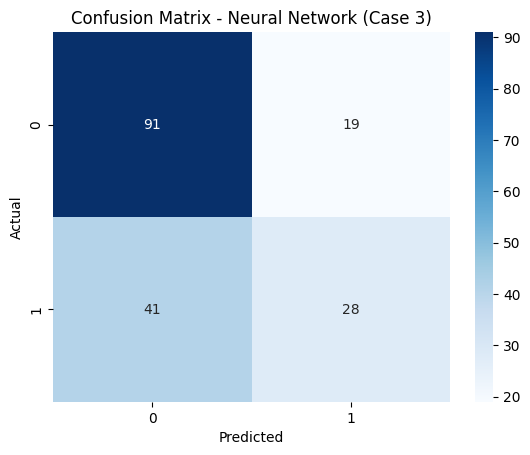

In [229]:
# - Create and train the neural network for Case 3
nn_model3 = MLPClassifier(
    hidden_layer_sizes=(50, 25, 10),
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
nn_model3.fit(X3_train, y3_train)

# - Predict on the test set for Case 3
y3_nn_pred = nn_model3.predict(X3_test)

# - Print classification results
print("Results for Neural Network on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_nn_pred))

# - Generate confusion matrix and display as heatmap
cm_nn3 = confusion_matrix(y3_test, y3_nn_pred)
sns.heatmap(cm_nn3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network (Case 3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


What this shows: The Neural Network’s confusion matrix, bottom-right is correct survivors, top-left is correct non-survivors; off-diagonals are mistakes.

### 5.4 Visualize Neural Network Decision Surface
We will visualize the decision boundary learned by the neural network across the two input features (age and family_size).
This plot helps show how the model separates survivors from non-survivors.


c:\Repos\ml-bethspornitz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


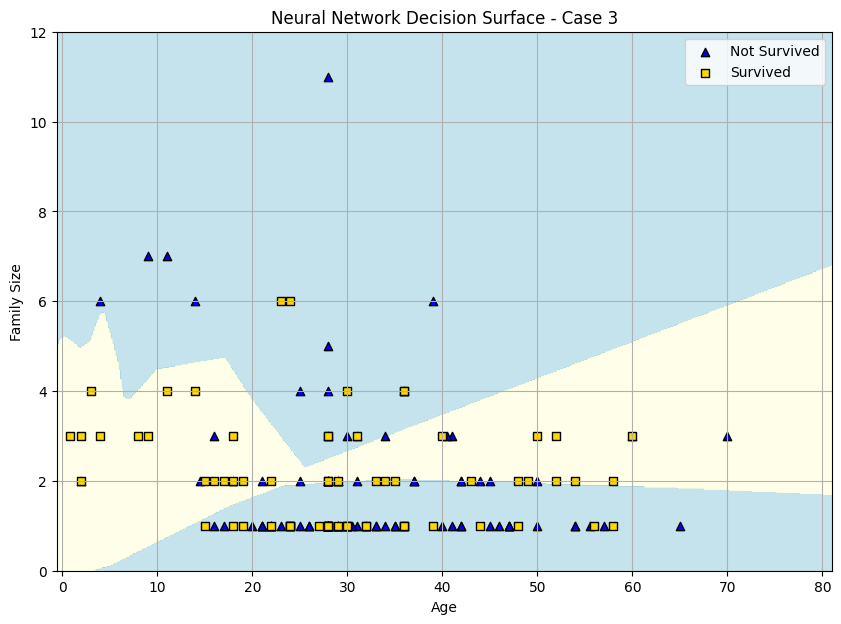

In [230]:
# - Define plotting range with padding for visualization clarity
padding = 1
x_min, x_max = X3['age'].min() - padding, X3['age'].max() + padding
y_min, y_max = X3['family_size'].min() - padding, X3['family_size'].max() + padding

# - Create a dense grid of age and family_size values
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

# - Predict survival outcomes for each point on the grid
Z = nn_model3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# - Plot decision surface background colors
plt.figure(figsize=(10, 7))
cmap_background = ListedColormap(['lightblue', 'lightyellow'])
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.7)

# - Overlay actual test points
plt.scatter(
    X3_test['age'][y3_test == 0],
    X3_test['family_size'][y3_test == 0],
    c='blue', marker='^', edgecolor='k', label='Not Survived'
)
plt.scatter(
    X3_test['age'][y3_test == 1],
    X3_test['family_size'][y3_test == 1],
    c='gold', marker='s', edgecolor='k', label='Survived'
)

# - Final chart formatting
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Neural Network Decision Surface - Case 3')
plt.legend()
plt.grid(True)
plt.show()


What this shows: Background colors are the NN’s predicted regions (not-survived vs survived) across age/family_size; markers show real test passengers laid on top.

### Reflection 5
How well did each of these new models perform (SVM and Neural Network)?  
- SVM (RBF): Typically outperforms a plain Decision Tree on these simple feature sets, especially Case 3 (age + family_size), because SVM can draw curved boundaries. Case 1 and Case 2 are weaker since each uses only one feature.
  
- Neural Network: Often comparable to SVM with two inputs. It can learn non-linear patterns, but with so few features it won’t massively exceed SVM unless tuned/scaled.
  
Were there any surprising results or insights?  
- Using only "alone" or only "age" limits all models while combining features (age + family_size) helps.

- The support vectors use dots to show "hard to decide" people which are the ones right between surviving and not surviving.  This model pays the most attention to these people when drawing a decision line.

- The Neural Network's colored background shows where it things people should survive or not survive.  If people land in the wrong color, it means the model is confused or making mistakes.
  
Why might one model outperform the others on this dataset?
- Decision Tree may outperform because it is great for rules, but it can be either too simple or overfit.

- SVM (RBF) is good for non-linear splits.

- Neural Network is flexible but needs adjustments.  Also, with only two features it won’t always beat SVM.


## Section 6. Final Thoughts and Insights
Summarize findings - important: use a table or other device to summarize your findings
Discuss challenges faced
Next steps to gain more insights and/or to explore classification models


| Model Type              | Case  | Features Used        | Accuracy | Precision | Recall | F1-Score | Notes |
|-------------------------|-------|------------------------|----------|-----------|--------|----------|-------|
| Decision Tree           | Case 1| alone                  | 63%      | 51%       | 58%    | 54%      | -     |
|                         | Case 2| age                    | 61%      | 50%       | 17%    | 26%      | -     |
|                         | Case 3| age + family_size      | 59%      | 46%       | 35%    | 40%      | -     |
| SVM (RBF Kernel)        | Case 1| alone                  | 63%      | 51%       | 58%    | 54%      | -     |
|                         | Case 2| age                    | 63%      | 71%       | 7%     | 13%      | -     |
|                         | Case 3| age + family_size      | 63%      | 71%       | 7%     | 13%      | -     |
| Neural Network (MLP)    | Case 3| age + family_size      | 66%      | 60%       | 41%    | 48%      | -     |



### Reflection 6
Discuss challenges faced
- It was confusing to me that more features like combined age and family size improved training accuracy but mad test accuracy worse.  I had to study why this was happening and understand more about overfitting where the model learning the training data so much that it fails to generalize.
- The decision tree visualizations were cluttered because they were split so many times, so I had to adjust the font size and figure size to make it more understandable.  
  
Next steps to gain more insights and/or to explore classification models:
- Try more useful features like sex and passenger class
- Experiment with tree pruning
